# Imports:

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import scipy.integrate as integ
import scienceplots
from cycler import cycler
import pycbc
import pycbc.waveform
from pycbc.waveform import Array
from pycbc.detector import Detector
import lal # this is for unit conversion
from astropy import coordinates
from astropy.time import Time
from tqdm import trange, tqdm
from multiprocessing import Pool
import os
import itertools
plt.style.use(['science','ieee','notebook'])
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['axes.prop_cycle'] = cycler('color', ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF', '#9A0EEA'])
plt.rcParams.update({'font.serif': 'serif', 'font.family' : 'DeJavu Serif'})
plt.rcParams.update({
        'font.size': 21,
        'axes.labelsize': 21,
        'xtick.labelsize': 18,
        'ytick.labelsize': 18,
        'legend.fontsize': 16
    })
frequencies = np.logspace(0,5,100000)

# Graphing Code:

In [29]:
def plot_SNR(x_vals, SNR_List, labels):
    
    plt.figure(figsize=(10, 8))
    for i, SNR in enumerate(SNR_List):
        plt.loglog(x_vals, SNR, label=labels[i], zorder=0)
    
    plt.ylim(1e-3)
    plt.xlim(1e-6,1e0)
    plt.grid(False)
    plt.gca().xaxis.grid(False, which='both')
    plt.gca().yaxis.grid(False, which='both')
    
    # Set all other ticks to point outwards
    plt.tick_params(direction='out', which='both')
    
    # Remove tick marks on the top x-axis and right y-axis
    plt.tick_params(axis='y', which='both', right=False)
    plt.tick_params(axis='x', which='both', top=False)
    
    plt.xlabel(r"Black Hole Masses (M$_{\odot}$)")
    plt.ylabel("SNR")
    plt.legend(frameon=True, ncols=2, loc='upper left')
    #plt.savefig('SSM PBH SNR v. Mass graph.pdf',format='pdf', dpi=300)
    plt.show()
    return

# Simulation Code:

In [30]:
def get_strain(Mc, q, DL, freqs, Faverage):
    """
    Gets numpy array of u_ph values at freqs
    """
    
    m1 = pycbc.conversions.mass1_from_mchirp_q(Mc,q)
    m2 = pycbc.conversions.mass2_from_mchirp_q(Mc,q)
    freqs_lal = Array(freqs)
    
    hp, _ = pycbc.waveform.get_fd_waveform_sequence(approximant = "IMRPhenomD", mass1 = m1, mass2 = m2, distance = DL, sample_points = freqs_lal, inclination = 0)
    F_ave = np.interp(freqs_lal, frequencies, Faverage)
    
    # Calculate the average values
    h_ave = np.abs(F_ave*hp)
    
    return h_ave

In [31]:
def SNR(hAve, asd, freqs):
    psd = np.interp(freqs, frequencies, asd**2)
    prod = 4. * integ.simps( (hAve**2) / psd , freqs)
    SNR = np.sqrt(prod)
    return SNR

In [32]:
def get_f_min(Mc, t_obs_secs):
    """Gets minimum frequency
    Args:
        Mc: Detector frame chirp mass [solar mass]
        Tobs: Time of observation [secs]
    Returns:
        fc: Minimum frequency [Hz]
    """
    Mc = lal.MTSUN_SI * Mc
    fcoal = 5.**(3./8.) / (8 * np.pi)
    fcoal *= 1 / (t_obs_secs ** (3./8.))
    fcoal *= 1 / (Mc ** (5./8.))
    return fcoal

In [33]:
def compute_task(S, Mc, q, dist, T_obs_secs, Faverage):
    
    SNR_array = []
    h_list = []
    # Calculate strain and SNR from input array of chirp masses
    for i in tqdm(range(len(Mc))):
        min_freq = get_f_min(Mc[i], T_obs_secs)
        m1 = pycbc.conversions.mass1_from_mchirp_q(Mc[i],q[i])
        m2 = pycbc.conversions.mass2_from_mchirp_q(Mc[i],q[i])
        max_freq = np.minimum((1/(2*(m1+m2)*lal.MTSUN_SI)),100000)
        freqRange = np.abs(int(max_freq)-int(min_freq)+1)
        freqs = np.logspace(np.log10(min_freq),np.log10(max_freq),freqRange)
        hAve = get_strain(Mc[i], q[i], dist, freqs, Faverage)
        temp_SNR = SNR(hAve, S, freqs)
        SNR_array.append(temp_SNR)
    return SNR_array

# Initialize inputs and run simulation:

In [34]:
mb=ml = np.logspace(-6, 0, 200) #black hole solar mass
dist = 0.03 # distance of boson cloud in Mpc
T_obs_secs =  604800
Mc = pycbc.conversions.mchirp_from_mass1_mass2(ml,mb)
q = mb/ml
ASD_list = []
srm_phi = [2,4,5,8,10] #excluding 0 (tuned) - always calculated

# Load in the ASD arrays for aLIGO and different detuning angles of GEO600 for vector and scalar specific detunings
with np.load('ASD_50W_100000_05.npz') as data:
    aLIGOasd = data['aLIGO']
    LIGO_list = [aLIGOasd]
    GEO600asd = data['GEO600']
    ASD_list.append(GEO600asd)
    for phi in srm_phi:
        asd_array = data[f'GEO600_{phi}']
        ASD_list.append(asd_array)

# Load in the antenna pattern arrays for GEO600 and LIGO:
with np.load('GEO_F_rms_100000_05.npz') as data:
        Faverage = data['F_rms']       
with np.load('LIGO_F_rms_100000_05.npz') as data:
        FaverageLIGO = data['F_rms']

# Number of cores to process (leaving one available)
num_cores = os.cpu_count() - 1

def fun_wrapper(args):
    return compute_task(args, Mc, q, dist, T_obs_secs, Faverage)
def fun_wrapper_LIGO(args):
    return compute_task(args, Mc, q, dist, T_obs_secs, FaverageLIGO)

with Pool(num_cores) as pool:
    SNR_List = list(pool.imap(fun_wrapper, ASD_list))
    temp_array = np.array(list(pool.imap(fun_wrapper_LIGO, LIGO_list)))
    SNR_List.append(temp_array[0])

  0%|                                                               | 0/200 [00:00<?, ?it/s]/var/folders/db/kn1xj4fj23g0d75vjsb3ykk80000gn/T/ipykernel_86586/3899297607.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  prod = 4. * integ.simps( (hAve**2) / psd , freqs)
/var/folders/db/kn1xj4fj23g0d75vjsb3ykk80000gn/T/ipykernel_86586/3899297607.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  prod = 4. * integ.simps( (hAve**2) / psd , freqs)
/var/folders/db/kn1xj4fj23g0d75vjsb3ykk80000gn/T/ipykernel_86586/3899297607.py:3: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  prod = 4. * integ.simps( (hAve**2) / psd , freqs)
/var/folders/db/kn1xj4fj23g0d75vjsb3ykk80000gn/T/ipykernel_86586/3899297607.py:3: DeprecationWarning: 'scip

# Plot Simulation:

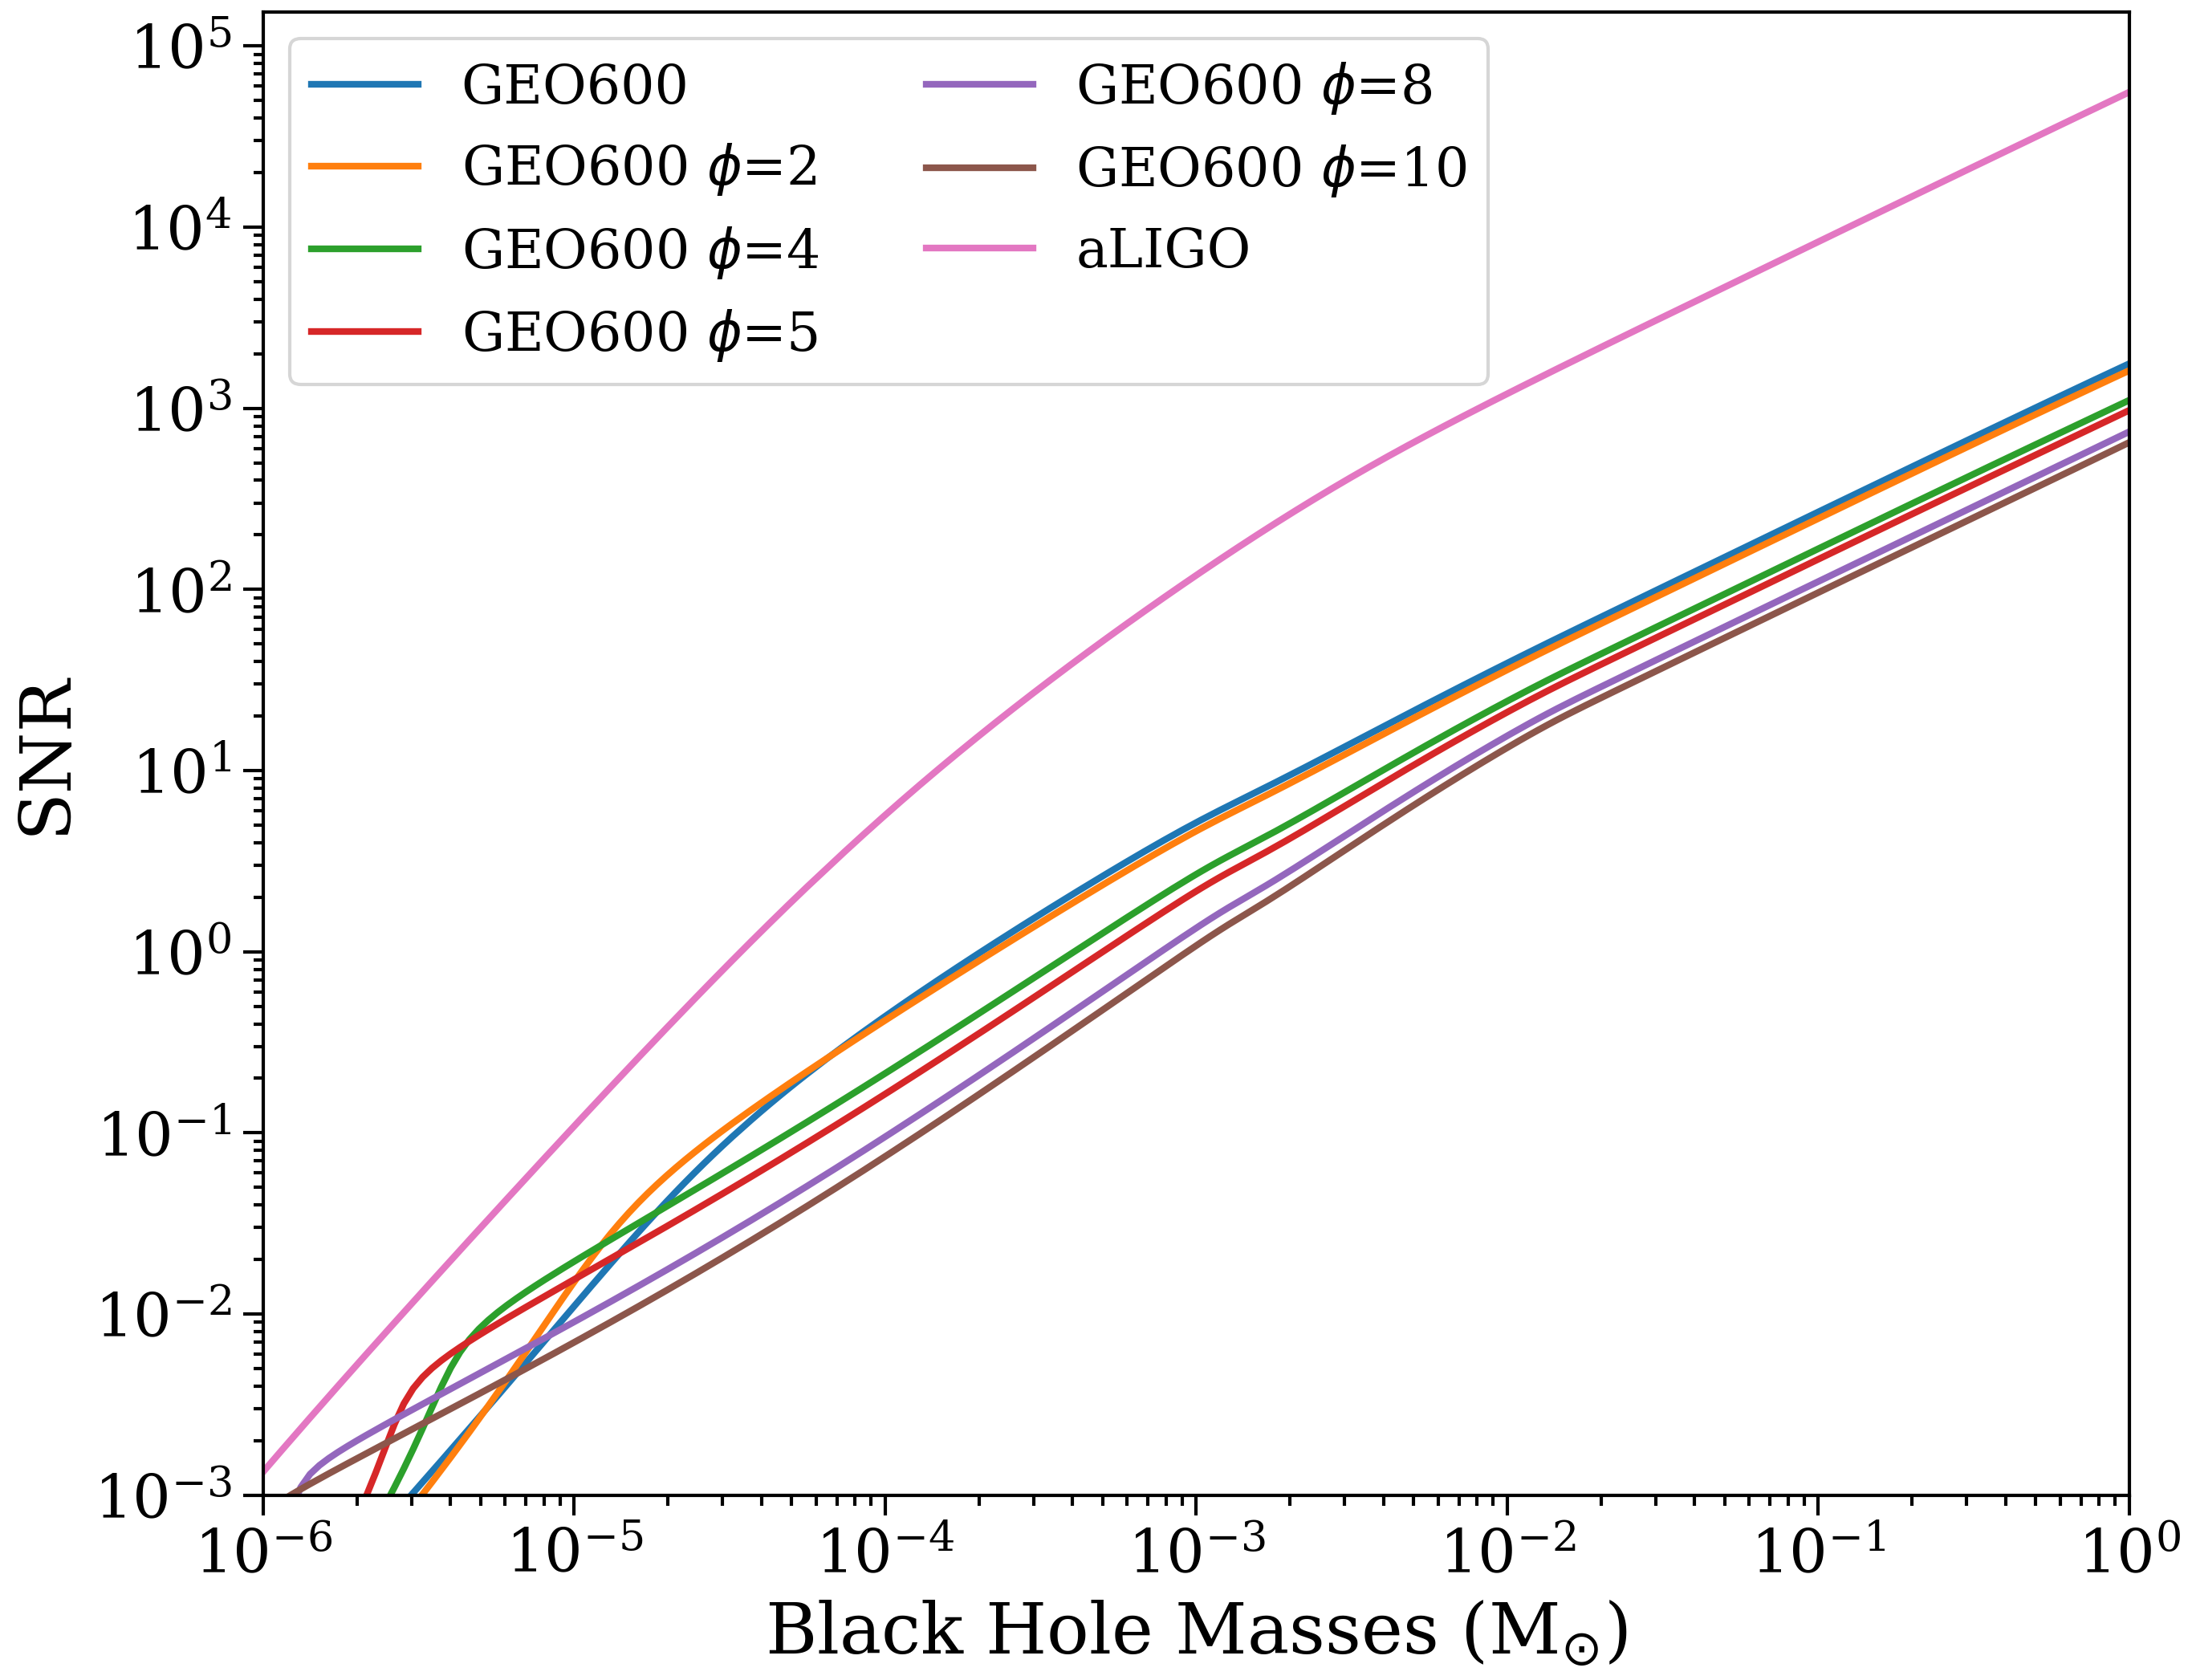

In [35]:
# Create labels and colors to use in graph:
labels = ['GEO600']
for phi in srm_phi:
    labels.append(f'GEO600 $\phi$={phi}')
labels.append('aLIGO')
# Graph:
plot_SNR(mb, SNR_List, labels)